## Trabajo practico final 

#### Materia: Analisis de datos cientificos y geograficos

#### Alumno: Valentina Allende

En el siguiente trabajo practico se analizan los datos obtenidos de las ondas cerebrales de una compañera en clase respecto a si tenia los ojos abiertos o cerrados. 
Primero se hara un analisis para entender como se comporta el cerebro en cada una de estas situaciones en lo referido a las frecuencias y los picos.
Finalmente a partir de estos datos se intenta predecir si una persona tiene los ojos abiertos o cerrados con el algoritmo de XGBClassifier.

In [233]:
#Se importan las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
import seaborn as sns
from scipy.fftpack import fft
import math
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, filtfilt, buttord
from scipy.signal import lfilter
from collections import Counter
from scipy import stats
from scipy.signal import find_peaks
from xgboost import XGBClassifier 
from bayes_opt import BayesianOptimization 
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, classification_report



#### Ojos abiertos

In [194]:
#Se lee el archivo de datos
signals = pd.read_csv('ojosabiertos.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

print('Estructura de la informacion:')
print(signals.head())

Estructura de la informacion:
      timestamp  counter  eeg  attention  meditation  blinking
0  1.702340e+09       68   83          0           0         0
1  1.702340e+09       69   70          0           0         0
2  1.702340e+09       70   71          0           0         0
3  1.702340e+09       71   60          0           0         0
4  1.702340e+09       72   36          0           0         0


In [195]:
data = signals.values
print (data)

[[1.70234048e+09 6.80000000e+01 8.30000000e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.70234048e+09 6.90000000e+01 7.00000000e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.70234048e+09 7.00000000e+01 7.10000000e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.70234054e+09 5.50000000e+01 9.20000000e+01 5.00000000e+01
  4.40000000e+01 0.00000000e+00]
 [1.70234054e+09 5.60000000e+01 9.80000000e+01 5.00000000e+01
  4.40000000e+01 0.00000000e+00]
 [1.70234054e+09 5.70000000e+01 1.12000000e+02 5.00000000e+01
  4.40000000e+01 0.00000000e+00]]


In [196]:
print('Forma %2d,%2d:' % (signals.shape))
eeg = data[:,2]
print(eeg)

Forma 30850, 6:
[ 83.  70.  71. ...  92.  98. 112.]


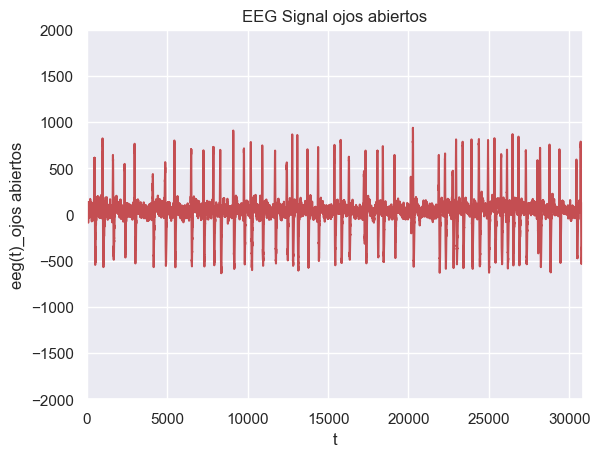

In [229]:
#Visualizamos las señales para ojos abiertos
plt.plot(eeg,'r', label='EEG')
plt.xlabel('t');
plt.ylabel('eeg(t)_ojos abiertos');
plt.title(r'EEG Signal ojos abiertos')     # r'' representa un raw string que no tiene caracteres especiales
plt.ylim([-2000, 2000]);
plt.xlim([0,len(eeg)])
plt.savefig('grafico.eps')
plt.show()



##### Se definen las funciones con las que trabajaremos los datos



In [198]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def psd(y):
    # Number of samplepoints
    N = 128
    # sample spacing
    T = 1.0 / 128.0
    # From 0 to N, N*T, 2 points.
    #x = np.linspace(0.0, 1.0, N)
    #y = 1*np.sin(10.0 * 2.0*np.pi*x) + 9*np.sin(20.0 * 2.0*np.pi*x)


    # Original Bandpass
    fs = 128.0
    fso2 = fs/2
    #Nd,wn = buttord(wp=[9/fso2,11/fso2], ws=[8/fso2,12/fso2],
    #   gpass=3.0, gstop=40.0)
    #b,a = butter(Nd,wn,'band')
    #y = filtfilt(b,a,y)

    y = butter_bandpass_filter(y, 8.0, 15.0, fs, order=6)


    yf = fft(y)
    #xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))
    #import matplotlib.pyplot as plt
    #plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
    #plt.axis((0,60,0,1))
    #plt.grid()
    #plt.show()

    return np.sum(np.abs(yf[0:int(N/2)]))

def crest_factor(x):
    return np.max(np.abs(x))/np.sqrt(np.mean(np.square(x)))

def hjorth(a):
    r"""
    Compute Hjorth parameters [HJO70]_.
    .. math::
        Activity = m_0 = \sigma_{a}^2
    .. math::
        Complexity = m_2 = \sigma_{d}/ \sigma_{a}
    .. math::
        Morbidity = m_4 =  \frac{\sigma_{dd}/ \sigma_{d}}{m_2}
    Where:
    :math:`\sigma_{x}^2` is the mean power of a signal :math:`x`. That is, its variance, if it's mean is zero.
    :math:`a`, :math:`d` and :math:`dd` represent the original signal, its first and second derivatives, respectively.
    .. note::
        **Difference with PyEEG:**
        Results is different from [PYEEG]_ which appear to uses a non normalised (by the length of the signal) definition of the activity:
        .. math::
            \sigma_{a}^2 = \sum{\mathbf{x}[i]^2}
        As opposed to
        .. math::
            \sigma_{a}^2 = \frac{1}{n}\sum{\mathbf{x}[i]^2}
    :param a: a one dimensional floating-point array representing a time series.
    :type a: :class:`~numpy.ndarray` or :class:`~pyrem.time_series.Signal`
    :return: activity, complexity and morbidity
    :rtype: tuple(float, float, float)
    Example:
    >>> import pyrem as pr
    >>> import numpy as np
    >>> # generate white noise:
    >>> noise = np.random.normal(size=int(1e4))
    >>> activity, complexity, morbidity = pr.univariate.hjorth(noise)
    """

    first_deriv = np.diff(a)
    second_deriv = np.diff(a,2)

    var_zero = np.mean(a ** 2)
    var_d1 = np.mean(first_deriv ** 2)
    var_d2 = np.mean(second_deriv ** 2)

    activity = var_zero
    morbidity = np.sqrt(var_d1 / var_zero)
    complexity = np.sqrt(var_d2 / var_d1) / morbidity

    return activity, morbidity, complexity

def pfd(a):
    r"""
    Compute Petrosian Fractal Dimension of a time series [PET95]_.
    It is defined by:
    .. math::
        \frac{log(N)}{log(N) + log(\frac{N}{N+0.4N_{\delta}})}
    .. note::
        **Difference with PyEEG:**
        Results is different from [PYEEG]_ which implemented an apparently erroneous formulae:
        .. math::
            \frac{log(N)}{log(N) + log(\frac{N}{N}+0.4N_{\delta})}
    Where:
    :math:`N` is the length of the time series, and
    :math:`N_{\delta}` is the number of sign changes.
    :param a: a one dimensional floating-point array representing a time series.
    :type a: :class:`~numpy.ndarray` or :class:`~pyrem.time_series.Signal`
    :return: the Petrosian Fractal Dimension; a scalar.
    :rtype: float
    Example:
    >>> import pyrem as pr
    >>> import numpy as np
    >>> # generate white noise:
    >>> noise = np.random.normal(size=int(1e4))
    >>> pr.univariate.pdf(noise)
    """

    diff = np.diff(a)
    # x[i] * x[i-1] for i in t0 -> tmax
    prod = diff[1:-1] * diff[0:-2]

    # Number of sign changes in derivative of the signal
    N_delta = np.sum(prod < 0)
    n = len(a)

    return np.log(n)/(np.log(n)+np.log(n/(n+0.4*N_delta)))


In [199]:
ptp = abs(np.max(eeg)) + abs(np.min(eeg))
rms = np.sqrt(np.mean(eeg**2))
cf = crest_factor(eeg)

print ('Peak-To-Peak:' + str(ptp))
print ('Root Mean Square:' + str(rms))
print ('Crest Factor:' + str(cf))

Peak-To-Peak:1574.0
Root Mean Square:203.56035044252909
Crest Factor:4.607970058809779


In [200]:
entropy = stats.entropy(list(Counter(eeg).values()), base=2)

print('Shannon Entropy:' + str(entropy))

Shannon Entropy:8.64899071407741


In [201]:
activity, complexity, morbidity = hjorth(eeg)

print('Activity:' + str(activity))
print('Complexity:' + str(complexity))
print('Mobidity:' + str(morbidity))

Activity:41436.81627228525
Complexity:0.097688790238713
Mobidity:9.343608039920838


In [202]:
fractal = pfd(eeg)
print('Fractal:' + str(fractal))

Fractal:1.0106825249255231


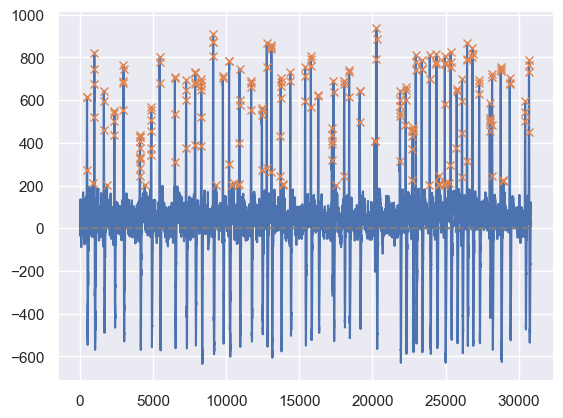

In [230]:
#Visualizacion para buscar picos en los datos
peaks, _ = find_peaks(eeg, height=200)
plt.plot(eeg)
plt.plot(peaks, eeg[peaks], "x")
plt.plot(np.zeros_like(eeg), "--", color="gray")
plt.show()

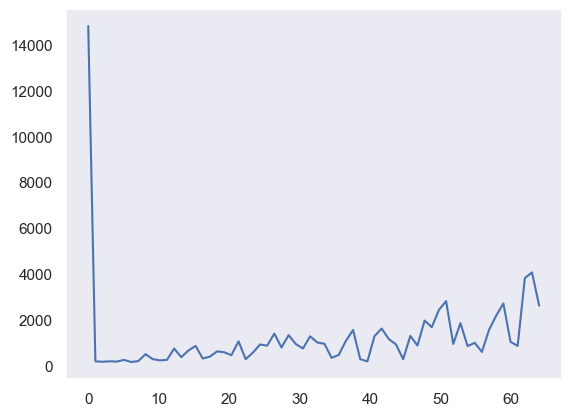

PSD:5905.987017339532


In [204]:
N = 128
T = 1.0 / 128.0

# We can put an additional frequency component to verify that things are working ok
shamsignal = False
if (shamsignal):
    x= np.linspace(0.0, 1.0, N)
    eeg = eeg[:128] +  100*np.sin(10.0 * 2.0*np.pi*x)


yf = fft(eeg)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.close()

plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.show()

print('PSD:' + str(psd(eeg[:128])))

In [205]:
#Definimos las ventanas y el desplazamiento
window_size = 128  # Tamaño de la ventana
step_size = 64  # Tamaño del desplazamiento entre ventanas

eeg_data = signals['eeg'].values

# Listas para almacenar los resultados
ojos_abiertos_ = []


# Iteramos
for i in range(0, len(eeg_data) - window_size + 1, step_size):
    window = eeg_data[i:i+window_size]  # Obtener la ventana actual

    # Calcular características para esta ventana
    psd_val = psd(window)


    # Guardar los valores
    ojos_abiertos_.append(psd_val)

In [206]:
ojos_abiertos_[0:10]

[5905.987017339532,
 4960.43538523806,
 2770.095219646494,
 3948.066331345349,
 3340.3825673705364,
 3428.1349924651286,
 3586.841218366694,
 4874.979472757274,
 9320.470716196578,
 6389.894933501846]

##### Ojos cerrados

In [207]:
ojos_cerrados = pd.read_csv('ojoscerrados.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

print('Estructura de la informacion:')
print(ojos_cerrados.head())

Estructura de la informacion:
      timestamp  counter  eeg  attention  meditation  blinking
0  1.702341e+09       32  -42          0           0         0
1  1.702341e+09       33  -37          0           0         0
2  1.702341e+09       34  -42          0           0         0
3  1.702341e+09       35  -54          0           0         0
4  1.702341e+09       36  -51          0           0         0


In [208]:
data_cerrados = ojos_cerrados.values
print (data_cerrados)

[[ 1.70234071e+09  3.20000000e+01 -4.20000000e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.70234071e+09  3.30000000e+01 -3.70000000e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.70234071e+09  3.40000000e+01 -4.20000000e+01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.70234077e+09  5.60000000e+01  1.70000000e+01  5.60000000e+01
   4.00000000e+01  0.00000000e+00]
 [ 1.70234077e+09  5.70000000e+01  2.60000000e+01  5.60000000e+01
   4.00000000e+01  0.00000000e+00]
 [ 1.70234077e+09  5.80000000e+01  4.40000000e+01  5.60000000e+01
   4.00000000e+01  0.00000000e+00]]


In [209]:
print('Forma %2d,%2d:' % (ojos_cerrados.shape))
eeg_cerrados = data_cerrados[:,2]
print(eeg_cerrados)

Forma 30887, 6:
[-42. -37. -42. ...  17.  26.  44.]


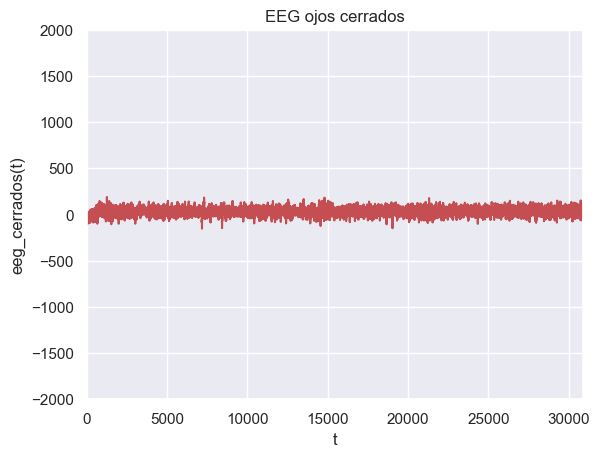

In [210]:
#Visualizamos las señales para ojos abiertos
plt.plot(eeg_cerrados,'r', label='EEG')
plt.xlabel('t');
plt.ylabel('eeg_cerrados(t)');
plt.title(r'EEG ojos cerrados')     # r'' representa un raw string que no tiene caracteres especiales
plt.ylim([-2000, 2000]);
plt.xlim([0,len(eeg_cerrados)])
plt.savefig('grafico.eps')
plt.show()

In [211]:
ptp = abs(np.max(eeg_cerrados)) + abs(np.min(eeg_cerrados))
rms = np.sqrt(np.mean(eeg_cerrados**2))
cf = crest_factor(eeg_cerrados)

print ('Peak-To-Peak:' + str(ptp))
print ('Root Mean Square:' + str(rms))
print ('Crest Factor:' + str(cf))

Peak-To-Peak:343.0
Root Mean Square:47.91195343708647
Crest Factor:3.9447358423441714


In [212]:
fractal = pfd(eeg_cerrados)
print('Fractal:' + str(fractal))

Fractal:1.0105875387403793


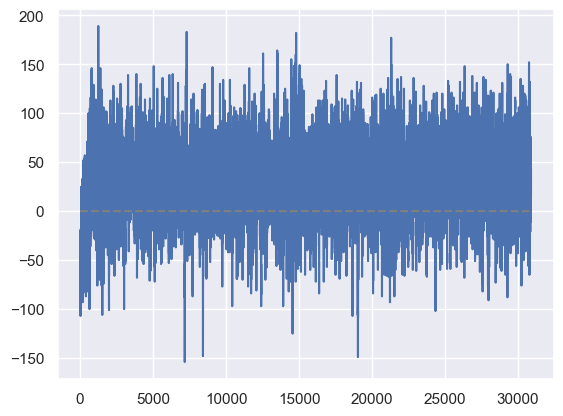

In [213]:
#Visualizacion para buscar picos en los datos
peaks, _ = find_peaks(eeg_cerrados, height=200)
plt.plot(eeg_cerrados)
plt.plot(peaks, eeg_cerrados[peaks], "x")
plt.plot(np.zeros_like(eeg_cerrados), "--", color="gray")
plt.show()

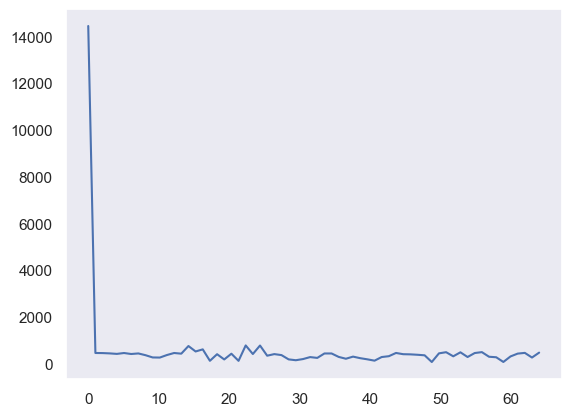

PSD:2451.8497974985034


In [214]:
N = 128
T = 1.0 / 128.0

# We can put an additional frequency component to verify that things are working ok
shamsignal = False
if (shamsignal):
    x= np.linspace(0.0, 1.0, N)
    eeg_cerrados = eeg_cerrados[:128] +  100*np.sin(10.0 * 2.0*np.pi*x)


yf = fft(eeg_cerrados)
xf = np.linspace(0.0, int(1.0/(2.0*T)), int(N/2))

plt.close()

plt.plot(xf, 2.0/N * np.abs(yf[0:int(N/2)]))
plt.grid()
plt.show()

print('PSD:' + str(psd(eeg_cerrados[:128])))

In [215]:
window_size = 128  # Tamaño de la ventana
step_size = 64  # Tamaño del desplazamiento entre ventanas

eeg_data = ojos_cerrados['eeg'].values

# Listas para almacenar los resultados
ojos_cerrados_ = []


# Iteramos
for i in range(0, len(eeg_data) - window_size + 1, step_size):
    window = eeg_data[i:i+window_size]  # Obtener la ventana actual

    # Calcular características para esta ventana
    psd_val = psd(window)


    # Guardar los valores
    ojos_cerrados_.append(psd_val)

In [216]:
ojos_cerrados_[0:10]

[2451.8497974985034,
 2511.6528375426174,
 3693.6816415091744,
 3800.6910998530066,
 2683.0713159075103,
 3233.104320274982,
 2668.469496307031,
 2413.3219425632205,
 3023.1374096984523,
 2327.0881364718152]

### Se arma el modelo

In [217]:
df_oa = pd.DataFrame(ojos_abiertos_ ,columns=['PSD'])
df_oa["Estado"] = 1
df_oa

,PSD,Estado
0,5905.987017,1
1,4960.435385,1
2,2770.095220,1
3,3948.066331,1
4,3340.382567,1
...,...,...
476,4995.317813,1
477,4116.264923,1
478,2852.880774,1
479,3200.141171,1


In [218]:
df_oc = pd.DataFrame(ojos_cerrados_ ,columns=['PSD'])
df_oc["Estado"] = 0
df_oc

,PSD,Estado
0,2451.849797,0
1,2511.652838,0
2,3693.681642,0
3,3800.691100,0
4,2683.071316,0
...,...,...
476,2808.207679,0
477,2995.272880,0
478,2346.753496,0
479,4678.427310,0


In [219]:
df = pd.concat([df_oa, df_oc], ignore_index=True)
df

,PSD,Estado
0,5905.987017,1
1,4960.435385,1
2,2770.095220,1
3,3948.066331,1
4,3340.382567,1
...,...,...
957,2808.207679,0
958,2995.272880,0
959,2346.753496,0
960,4678.427310,0


In [222]:
X = df.drop(['Estado'], axis=1)
y = df[['Estado']]

In [223]:
#Dividimos el dataset en entrenamiento y test
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=.4, random_state = 42)

In [224]:
# Limites inferiores y superiores de los hiperparametros que vamos a optimizar.
pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0),  # Subsample lo dejamos en 1 que es default para XGBoost ya que no son muchos datos.
    'colsample': (1.0, 1.0),  # Como no hay muchas variables también lo dejamos en uno.
    'gamma': (0, 5)}


In [225]:
# Función de optimización de los hiperparametros
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample,
                        gamma):
    # Se transforman max_depth y n_estimators en int ya que XGBoost no acepta float.
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    # Instanciación del XGBClassifier con objetivo multi clasificación
    clf = XGBClassifier(objective="binary:logistic",
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    
    # Retornamos el valor de accuracy obtenido por el modelo
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='precision'))

In [226]:

# Instanciacion de la optimización bayesiana.
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(init_points=20, n_iter=4)

print('Mejor Resultado:', optimizer.max)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------


| 1         | 0.775     | 1.0       | 3.602     | 0.01011   | 5.116     | 232.1     | 1.0       |
| 2         | 0.6639    | 1.0       | 1.728     | 0.4028    | 6.772     | 477.3     | 1.0       |
| 3         | 0.8286    | 1.0       | 4.391     | 0.03711   | 7.693     | 475.6     | 1.0       |
| 4         | 0.6342    | 1.0       | 0.9905    | 0.8027    | 9.778     | 382.1     | 1.0       |
| 5         | 0.8286    | 1.0       | 4.473     | 0.09419   | 3.273     | 252.8     | 1.0       |
| 6         | 0.6195    | 1.0       | 2.106     | 0.9583    | 6.732     | 722.7     | 1.0       |
| 7         | 0.8286    | 1.0       | 4.173     | 0.02811   | 8.251     | 990.0     | 1.0       |
| 8         | 0.8286    | 1.0       | 3.946     | 0.1122    | 6.135     | 917.7     | 1.0       |
| 9         | 0.6465    | 1.0       | 0.6501    | 0.02917   | 7.752     | 290.5     | 1.0       |
| 10        | 0.6035    | 1.0       | 0.2668    | 0.5784    | 4.027     | 630.4     | 1.0       |
| 11        | 0.6836

d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\A

| 21        | 0.775     | 1.0       | 3.498     | 0.09245   | 4.648     | 232.0     | 1.0       |


d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\A

| 22        | 0.7696    | 1.0       | 3.197     | 0.5271    | 9.234     | 916.0     | 1.0       |


d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\A

| 23        | 0.727     | 1.0       | 2.327     | 0.3096    | 4.583     | 914.5     | 1.0       |


d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\Anaconda\envs\dhdsblend2021\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
d:\A

| 24        | 0.7194    | 1.0       | 1.588     | 0.433     | 8.818     | 912.4     | 1.0       |
Mejor Resultado: {'target': 0.8444444444444444, 'params': {'colsample': 1.0, 'gamma': 2.574445560291543, 'learning_rate': 0.9451488084309052, 'max_depth': 7.105885283513951, 'n_estimators': 913.0617237590951, 'subsample': 1.0}}


In [227]:
modelo = XGBClassifier(
    objective="binary:logistic",
        max_depth=7,
        learning_rate=0.9451488084309052,
        n_estimators=913,
        gamma=2.574445560291543)

modelo.fit(X_train, y_train)

# Predecimos los valores del conjunto de testeo y lo almacenamos en una variable para ver su accuracy
y_predict = modelo.predict(X_test)

print("Accuracy del modelo:", accuracy_score( y_test, y_predict))

Accuracy del modelo: 0.5558441558441558


In [228]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.52      0.92      0.67       186
           1       0.75      0.21      0.33       199

    accuracy                           0.56       385
   macro avg       0.64      0.57      0.50       385
weighted avg       0.64      0.56      0.49       385



In [234]:
print(confusion_matrix(y_test, y_predict))

[[ 95  91]
 [102  97]]


#### Conclusiones

En el transcurso del analisis de la información se pudo ver que la señal analizada para ojos abiertos, presenta picos a lo largo del tiempo, mientras que con ojos abiertos no se observan picos. Al analizar la señal en el dominio de la frecuencia, se puede observar que para ojos abiertos, la señal presenta valores mas altos, y una señal mas continua. Para ojos cerrados, la señal presenta valores mas bajos, y una señal mas suave. Finalmente, se desarrollo un modelo de clasificacion con el algoritmo XGBoost, con el proposito de predecir si la persona tenia los ojos abiertos o cerrados, el cual obtuvo un accuracy de 0.56. A partir de ese resultado se puede concluir que el modelo no es bueno, ya que no es capaz de predecir correctamente si la persona tiene los ojos abiertos o cerrados.
Esto se refuerza a partir del resto de las metricas: precision con un 52% de aciertos para la clase 0 y 75% para la clase 1; un recall de 92% para la clase 0 y solo del 21% para la clase 1; y un f1-score de 67% para la clase 0 y 33% para la clase 1.